In [1]:
# 異常として分類するラベル
target = 9

In [2]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm

TRAIN = True

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.13, ), (0.3, ))])

trainset = torchvision.datasets.MNIST(root='./data', 
                                        train=True,
                                        download=True,
                                        transform=transform)

testset = torchvision.datasets.MNIST(root='./data', 
                                        train=False, 
                                        download=True, 
                                        transform=transform)

classes = tuple(np.linspace(0, 9, 10, dtype=np.uint8))

In [3]:
raw_y = np.array([int(y) for y in trainset.targets])
raw_x = np.array([y for y in trainset.data.numpy()])

In [4]:
idx = trainset.train_labels!=target
trainset.targets = trainset.targets[idx]
trainset.data = trainset.data[idx]

/home/ken/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [5]:
idx = testset.train_labels==target
testset.targets = testset.targets[idx]
testset.data = testset.data[idx]

set dataloader

In [6]:
trainloader = torch.utils.data.DataLoader(trainset,
                                            batch_size=100,
                                            shuffle=True,
                                            num_workers=0)
testloader = torch.utils.data.DataLoader(testset, 
                                            batch_size=100,
                                            shuffle=False, 
                                            num_workers=0)

In [7]:
# 正常データをサンプル
testset_norm = torchvision.datasets.MNIST(root='./data', 
                                        train=False, 
                                        download=True, 
                                        transform=transform)
idx = testset_norm.train_labels!=target
testset_norm.targets = testset_norm.targets[idx]
testset_norm.data = testset_norm.data[idx]
testloader1 = torch.utils.data.DataLoader(testset_norm, 
                                            batch_size=100,
                                            shuffle=False, 
                                            num_workers=0)


## define model

In [8]:
import pretrainedmodels
model_name = "resnet18"
basemodel = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
basemodel = nn.Sequential(*list(basemodel.children())[1:-2])

In [9]:
from metrics import ArcMarginProduct
class mymodel(nn.Module):
    def __init__(self):
        super(mymodel, self).__init__()
        self.features = basemodel
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1, bias=False)
        if model_name == "resnet34" or model_name == "resnet18":
            num_ch = 512
        else:
            num_ch = 2048
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        # 全結合層で圧縮
        self.fc1 = nn.Linear(num_ch, 3)
        #self.fc2 = nn.Linear(64, 3)
        self.prelu_weight = nn.Parameter(torch.Tensor(1).fill_(0.25))
        
    def forward(self, x):
        # extract features
        x = self.conv1(x)
        x = self.features(x)
        x = self.avgpool(x).squeeze(2).squeeze(2)
        x = F.prelu(self.fc1(x), self.prelu_weight)
        
        return x

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = mymodel()
model = model.to(device)

# define arcface

In [11]:
from metrics import AddMarginProduct
metric_fc = AddMarginProduct(3, 9, s=3).to(device)
criterion = torch.nn.CrossEntropyLoss()

# optimzer nn
optimizer_nn = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

# optimzer cosface or arcface
optimzer_arcface = torch.optim.SGD(metric_fc.parameters(), lr=0.01)

## train script

In [12]:
def train(epoch):
    model.train()
    print('epochs {}/{} '.format(epoch+1,epochs))
    running_loss = 0.0
    running_acc = 0.0
    acc1 = 0.0
    acc2 = 0.0
    acc3 = 0.0
    t = tqdm(trainloader)
    
    for idx, (inputs,labels1) in enumerate(t):       
        # send to gpu
        inputs = inputs.to(device)
        labels1 = labels1.to(device)
        
        # set opt
        optimizer_nn.zero_grad()
        optimzer_arcface.zero_grad()
        
        # run model
        feat = model(inputs.float())
        outputs = metric_fc(feat, labels1)

        loss = criterion(outputs,labels1)
        loss.backward()
        
        optimizer_nn.step()
        optimzer_arcface.step()
        
        # Compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (labels1.data == predicted).float().mean()
        
        if idx%100==0:
            print("loss:",loss.item())
            print("acc:", accuracy)
        

In [13]:
epochs = 20
if TRAIN:
    for epoch in range(epochs):
        train(epoch)
        torch.save(model.state_dict(), './saved_weights.pth')
else:
    model.load_state_dict(torch.load('./saved_weights.pth'))

epochs 1/20 


<ipython-input-12-81a1e1149074>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(trainloader)


loss: 4.65086030960083
acc: tensor(0., device='cuda:0')
loss: 1.3397386074066162
acc: tensor(0.2100, device='cuda:0')
loss: 1.1866910457611084
acc: tensor(0.8600, device='cuda:0')
loss: 1.183295488357544
acc: tensor(0.9000, device='cuda:0')
loss: 1.1350282430648804
acc: tensor(0.9300, device='cuda:0')
loss: 1.1484025716781616
acc: tensor(0.9700, device='cuda:0')

epochs 2/20 


loss: 1.1780427694320679
acc: tensor(0.9400, device='cuda:0')
loss: 1.116863489151001
acc: tensor(0.9700, device='cuda:0')
loss: 1.1395853757858276
acc: tensor(0.9700, device='cuda:0')
loss: 1.226227879524231
acc: tensor(0.9500, device='cuda:0')
loss: 1.190018653869629
acc: tensor(0.9500, device='cuda:0')
loss: 1.1381438970565796
acc: tensor(0.9700, device='cuda:0')

epochs 3/20 


loss: 1.168989658355713
acc: tensor(0.9500, device='cuda:0')
loss: 1.0754141807556152
acc: tensor(1., device='cuda:0')
loss: 1.1164416074752808
acc: tensor(0.9700, device='cuda:0')
loss: 1.080198884010315
acc: tensor(0.9900, device='cuda:0')
loss: 1.1399174928665161
acc: tensor(0.9900, device='cuda:0')
loss: 1.0724931955337524
acc: tensor(1., device='cuda:0')

epochs 4/20 


loss: 1.0766615867614746
acc: tensor(1., device='cuda:0')
loss: 1.0736545324325562
acc: tensor(1., device='cuda:0')
loss: 1.138896107673645
acc: tensor(0.9800, device='cuda:0')
loss: 1.0919575691223145
acc: tensor(0.9900, device='cuda:0')
loss: 1.0742355585098267
acc: tensor(1., device='cuda:0')
loss: 1.0713295936584473
acc: tensor(1., device='cuda:0')

epochs 5/20 


loss: 1.0873066186904907
acc: tensor(0.9900, device='cuda:0')
loss: 1.1009382009506226
acc: tensor(0.9900, device='cuda:0')
loss: 1.1412973403930664
acc: tensor(0.9800, device='cuda:0')
loss: 1.0784775018692017
acc: tensor(0.9700, device='cuda:0')
loss: 1.080633521080017
acc: tensor(0.9900, device='cuda:0')
loss: 1.1268484592437744
acc: tensor(0.9800, device='cuda:0')

epochs 6/20 


loss: 1.118910551071167
acc: tensor(0.9800, device='cuda:0')
loss: 1.0718497037887573
acc: tensor(1., device='cuda:0')
loss: 1.0735379457473755
acc: tensor(0.9900, device='cuda:0')
loss: 1.0770995616912842
acc: tensor(1., device='cuda:0')
loss: 1.0840970277786255
acc: tensor(0.9900, device='cuda:0')
loss: 1.0778944492340088
acc: tensor(1., device='cuda:0')

epochs 7/20 


loss: 1.0687261819839478
acc: tensor(1., device='cuda:0')
loss: 1.0682744979858398
acc: tensor(1., device='cuda:0')
loss: 1.1101890802383423
acc: tensor(0.9800, device='cuda:0')
loss: 1.0793391466140747
acc: tensor(0.9900, device='cuda:0')
loss: 1.149744987487793
acc: tensor(0.9800, device='cuda:0')
loss: 1.0762436389923096
acc: tensor(1., device='cuda:0')

epochs 8/20 


loss: 1.071845531463623
acc: tensor(0.9900, device='cuda:0')
loss: 1.0688731670379639
acc: tensor(1., device='cuda:0')
loss: 1.0815844535827637
acc: tensor(0.9900, device='cuda:0')
loss: 1.0939770936965942
acc: tensor(0.9900, device='cuda:0')
loss: 1.071825385093689
acc: tensor(1., device='cuda:0')
loss: 1.0771268606185913
acc: tensor(1., device='cuda:0')

epochs 9/20 


loss: 1.0679525136947632
acc: tensor(1., device='cuda:0')
loss: 1.074374794960022
acc: tensor(1., device='cuda:0')
loss: 1.0764265060424805
acc: tensor(1., device='cuda:0')
loss: 1.1337306499481201
acc: tensor(0.9900, device='cuda:0')
loss: 1.0783636569976807
acc: tensor(0.9900, device='cuda:0')
loss: 1.0731642246246338
acc: tensor(1., device='cuda:0')

epochs 10/20 


loss: 1.0746417045593262
acc: tensor(1., device='cuda:0')
loss: 1.080764889717102
acc: tensor(1., device='cuda:0')
loss: 1.114791750907898
acc: tensor(0.9800, device='cuda:0')
loss: 1.0710071325302124
acc: tensor(1., device='cuda:0')
loss: 1.1358085870742798
acc: tensor(0.9700, device='cuda:0')
loss: 1.0870881080627441
acc: tensor(0.9800, device='cuda:0')

epochs 11/20 


loss: 1.0729655027389526
acc: tensor(1., device='cuda:0')
loss: 1.0761079788208008
acc: tensor(1., device='cuda:0')
loss: 1.142500877380371
acc: tensor(0.9800, device='cuda:0')
loss: 1.0740917921066284
acc: tensor(1., device='cuda:0')
loss: 1.0773600339889526
acc: tensor(1., device='cuda:0')
loss: 1.0768722295761108
acc: tensor(1., device='cuda:0')

epochs 12/20 


loss: 1.0768463611602783
acc: tensor(1., device='cuda:0')
loss: 1.0728219747543335
acc: tensor(1., device='cuda:0')
loss: 1.0714843273162842
acc: tensor(1., device='cuda:0')
loss: 1.066192865371704
acc: tensor(1., device='cuda:0')
loss: 1.0781300067901611
acc: tensor(1., device='cuda:0')
loss: 1.1143561601638794
acc: tensor(0.9800, device='cuda:0')

epochs 13/20 


loss: 1.0729283094406128
acc: tensor(1., device='cuda:0')
loss: 1.074571132659912
acc: tensor(1., device='cuda:0')
loss: 1.0875660181045532
acc: tensor(0.9900, device='cuda:0')
loss: 1.1117029190063477
acc: tensor(0.9800, device='cuda:0')
loss: 1.0777207612991333
acc: tensor(0.9900, device='cuda:0')
loss: 1.0724596977233887
acc: tensor(1., device='cuda:0')

epochs 14/20 


loss: 1.0698044300079346
acc: tensor(1., device='cuda:0')
loss: 1.106385588645935
acc: tensor(0.9800, device='cuda:0')
loss: 1.0735515356063843
acc: tensor(0.9900, device='cuda:0')
loss: 1.0999928712844849
acc: tensor(0.9900, device='cuda:0')
loss: 1.076175570487976
acc: tensor(0.9900, device='cuda:0')
loss: 1.0778762102127075
acc: tensor(1., device='cuda:0')

epochs 15/20 


loss: 1.0739291906356812
acc: tensor(1., device='cuda:0')
loss: 1.0740059614181519
acc: tensor(0.9900, device='cuda:0')
loss: 1.1030356884002686
acc: tensor(0.9800, device='cuda:0')
loss: 1.1163352727890015
acc: tensor(0.9900, device='cuda:0')
loss: 1.0851013660430908
acc: tensor(0.9800, device='cuda:0')
loss: 1.0709044933319092
acc: tensor(1., device='cuda:0')

epochs 16/20 


loss: 1.1862472295761108
acc: tensor(0.9500, device='cuda:0')
loss: 1.1073726415634155
acc: tensor(0.9900, device='cuda:0')
loss: 1.0758147239685059
acc: tensor(1., device='cuda:0')
loss: 1.0960447788238525
acc: tensor(0.9700, device='cuda:0')
loss: 1.0798351764678955
acc: tensor(1., device='cuda:0')
loss: 1.0766966342926025
acc: tensor(1., device='cuda:0')

epochs 17/20 


loss: 1.0753833055496216
acc: tensor(1., device='cuda:0')
loss: 1.0711103677749634
acc: tensor(1., device='cuda:0')
loss: 1.1044468879699707
acc: tensor(0.9900, device='cuda:0')
loss: 1.0979399681091309
acc: tensor(0.9900, device='cuda:0')
loss: 1.0892680883407593
acc: tensor(0.9900, device='cuda:0')
loss: 1.0630004405975342
acc: tensor(1., device='cuda:0')

epochs 18/20 


loss: 1.0740537643432617
acc: tensor(1., device='cuda:0')
loss: 1.0697616338729858
acc: tensor(1., device='cuda:0')
loss: 1.07195246219635
acc: tensor(1., device='cuda:0')
loss: 1.0709033012390137
acc: tensor(1., device='cuda:0')
loss: 1.0683751106262207
acc: tensor(1., device='cuda:0')
loss: 1.0973936319351196
acc: tensor(0.9900, device='cuda:0')

epochs 19/20 


loss: 1.072740077972412
acc: tensor(1., device='cuda:0')
loss: 1.0782510042190552
acc: tensor(1., device='cuda:0')
loss: 1.0849677324295044
acc: tensor(0.9900, device='cuda:0')
loss: 1.0683571100234985
acc: tensor(1., device='cuda:0')
loss: 1.07802152633667
acc: tensor(0.9900, device='cuda:0')
loss: 1.0819964408874512
acc: tensor(0.9900, device='cuda:0')

epochs 20/20 


loss: 1.079455852508545
acc: tensor(1., device='cuda:0')
loss: 1.077825665473938
acc: tensor(1., device='cuda:0')
loss: 1.0672218799591064
acc: tensor(1., device='cuda:0')
loss: 1.067861795425415
acc: tensor(1., device='cuda:0')
loss: 1.0738840103149414
acc: tensor(1., device='cuda:0')
loss: 1.129430890083313
acc: tensor(0.9800, device='cuda:0')



# 異常度の計算

In [49]:
from scipy import spatial
model.eval()
def cosin_metric(x1, x2):
    return np.dot(x1, x2) / (np.linalg.norm(x1) * np.linalg.norm(x2))

def cosin_metric_each(x1, x2):
    return np.dot(x1, x2) / (np.linalg.norm(x1, axis=1) * np.linalg.norm(x2))

In [50]:
with torch.no_grad():
    train = trainset[1][0]
    out1 = model(train.unsqueeze(0).to(device)).cpu().numpy()
    test = testset_norm[0][0]
    out2 = model(test.unsqueeze(0).to(device)).cpu().numpy()
    
print("same number:", cosin_metric(out1, out2.T))

same number: [[0.24205054]]


In [51]:
with torch.no_grad():
    train = trainset[1][0]
    out1 = model(train.unsqueeze(0).to(device)).cpu().numpy()
    test = testset[0][0]
    out2 = model(test.unsqueeze(0).to(device)).cpu().numpy()
    
print("diff number:", cosin_metric(out1, out2.T))

diff number: [[-0.8321636]]


In [16]:
torch.cuda.empty_cache()

## inference and evaluate distance.

In [17]:
t = tqdm(trainloader)  
for idx, (inputs,labels1) in enumerate(t):       
    # send to gpu
    inputs = inputs.to(device)
    labels1 = torch.zeros(inputs.size()[0]).to(device).long() #.unsqueeze(1)
    # run model
    with torch.no_grad():
        out = model(inputs.float())
    if idx  == 0:
        outs = out
    else:
        outs = torch.cat((outs, out))

normals = outs.cpu().numpy()

t = tqdm(testloader1)
norm_labels = []
for idx, (inputs,labels1) in enumerate(t):       
    # send to gpu
    inputs = inputs.to(device)
    norm_labels.extend(labels1.numpy())
    labels1 = torch.zeros(inputs.size()[0]).to(device).long() #.unsqueeze(1)
    # run model
    with torch.no_grad():
        out = model(inputs.float())
    if idx  == 0:
        outs = out
    else:
        outs = torch.cat((outs, out))

normals1 = outs.cpu().numpy()

t = tqdm(testloader)  
for idx, (inputs,labels1) in enumerate(t):       
    # send to gpu
    inputs = inputs.to(device)
    labels1 = torch.zeros(inputs.size()[0]).to(device).long() #.unsqueeze(1)
    # run model
    with torch.no_grad():
        out = model(inputs.float())
    if idx  == 0:
        outs = out
    else:
        outs = torch.cat((outs, out))
        
abnormals = outs.cpu().numpy()

<ipython-input-17-f7ca4b39054d>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(trainloader)


<ipython-input-17-f7ca4b39054d>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(testloader1)


<ipython-input-17-f7ca4b39054d>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(testloader)


In [18]:
# Compute ecidian distance
with torch.no_grad():
    test = testset[1][0]
    out2 = model(test.unsqueeze(0).to(device)).cpu().numpy()

print("different number:",np.linalg.norm(normals-out2))

with torch.no_grad():
    test = testset_norm[1][0]
    out2 = model(test.unsqueeze(0).to(device)).cpu().numpy()

print("same number:", np.linalg.norm(normals-out2))

different number: 1916.6825
same number: 2651.692


In [60]:
# cosine metric
a = normals[0:5]
print(a.shape)

with torch.no_grad():
    test = testset[2][0]
    out2 = model(test.unsqueeze(0).to(device)).cpu().numpy()
b = out2

print(out2.shape)

print(cosin_metric(a, b.T))
print(np.mean(cosin_metric_each(a, b.T), axis=1))

(5, 3)
(1, 3)
[[ 0.09947518]
 [ 0.22515933]
 [ 0.09172427]
 [ 0.08671882]
 [-0.44132552]]
[ 0.25590387  0.5792314   0.23596433  0.22308762 -1.1353276 ]


In [61]:
# cosine metric
a = normals[0:5]
print(a.shape)

with torch.no_grad():
    test = testset_norm[2][0]
    out2 = model(test.unsqueeze(0).to(device)).cpu().numpy()
b = out2

print(out2.shape)

print(cosin_metric(a, b.T))
print(np.mean(cosin_metric_each(a, b.T), axis=1))

(5, 3)
(1, 3)
[[ 0.15858875]
 [ 0.07727344]
 [-0.33331856]
 [-0.31523365]
 [ 0.22623758]]
[ 0.40797585  0.198789   -0.8574753  -0.8109511   0.58200526]


In [43]:
# compute cosine distance with my function
with torch.no_grad():
    test = testset[2][0]
    out2 = model(test.unsqueeze(0).to(device)).cpu().numpy()

print("different number:", np.mean(cosin_metric_each(normals, out2.T)))

with torch.no_grad():
    test = testset_norm[2][0]
    out2 = model(test.unsqueeze(0).to(device)).cpu().numpy()

print("same number:", np.mean(cosin_metric(normals, out2.T), axis=0))

different number: -0.00040335942
same number: [-0.00012256]


In [20]:
# compute cosine distance with scipy
with torch.no_grad():
    test = testset[2][0]
    out2 = model(test.unsqueeze(0).to(device)).cpu().numpy()
print("different number:", 1 - spatial.distance.cosine(normals[0,:], out2.T))

different number: 0.2236705720424652


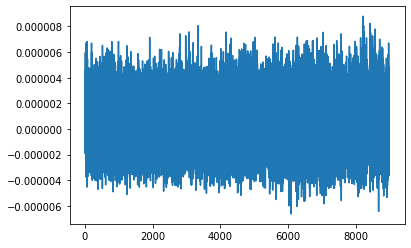

In [65]:
# print scatter plot of same 1s
# Euclidian
norm = []
for n in normals1:
    norm.append(np.linalg.norm(normals-n))
# Cosine simularity
norm = np.mean(cosin_metric(normals, normals1.T), axis=0)

import matplotlib.pyplot as plt
same = norm
plt.plot(same)
plt.show()

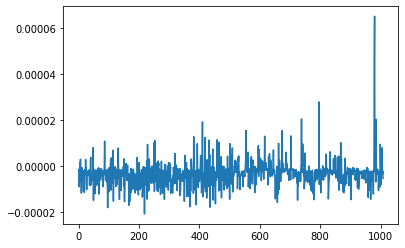

In [66]:
# print scatter plot of same 1s
# Euclidian
norm = []
for n in abnormals:
    norm.append(np.linalg.norm(normals-n))
    
# Cosine simularity
norm = np.mean(cosin_metric(normals, abnormals.T), axis=0)
import matplotlib.pyplot as plt
different = norm
plt.plot(different)
plt.show()

# 推論結果を3D可視化

In [23]:
# https://github.com/egcode/pytorch-losses/blob/master/mnist-visualize-arcface6_fc7-loss.ipynb
f3d = []
lbls = []
for i in range(len(testset_norm)):
    image_tensor, label_tensor = testloader1.dataset[i]
    label_tensor = torch.tensor(testloader1.dataset[i][1])
    image_tensor = image_tensor.reshape(1,1,28,28)

    image_tensor, label_tensor = image_tensor.to(device), label_tensor.to(device)

    features3d  = model(image_tensor)
    logits = metric_fc(features3d, torch.unsqueeze(label_tensor, dim=-1))
    _, prediction = torch.max(logits.data, 1)

    f3d.append(features3d[0].cpu().detach().numpy())
    
    prediction = prediction.cpu().detach().numpy()[0]
    lbls.append(prediction)

feat3d = np.array(f3d)
print("3d features shape" + str(feat3d.shape))

lbls = np.array(lbls)
print("labels shape" + str(lbls.shape))

3d features shape(8991, 3)
labels shape(8991,)


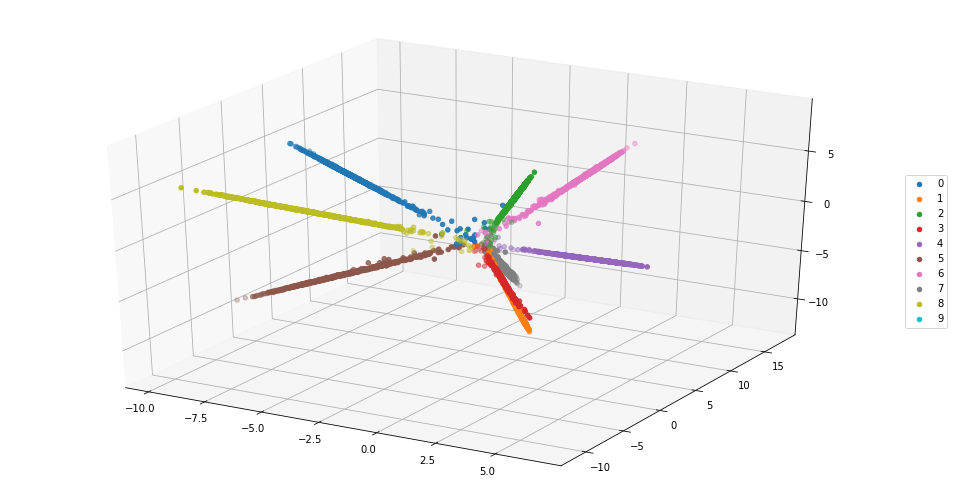

In [24]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(16,9))
ax = plt.axes(projection='3d')

for i in range(10):
    # Data for three-dimensional scattered points
    xdata = feat3d[lbls==i,2].flatten()
    ydata = feat3d[lbls==i,0].flatten()
    zdata = feat3d[lbls==i,1].flatten()
    ax.scatter3D(xdata, ydata, zdata);
ax.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

# Visualize by TSNE

## 普通の分類結果

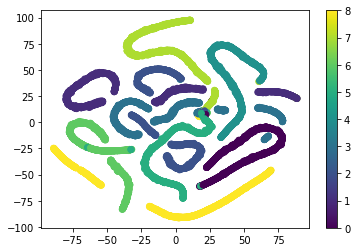

In [25]:
from sklearn.manifold import TSNE
# 特徴量抽出
feats = normals1
# ラベル情報追加

# TSNEをfit
tSNE_metrics = TSNE(n_components=2, random_state=0).fit_transform(feats)
plt.scatter(tSNE_metrics[:, 0], tSNE_metrics[:, 1], c=norm_labels)
plt.colorbar()
plt.savefig('tsne_classification.png')
plt.show()

## 異常ラベルとの比較

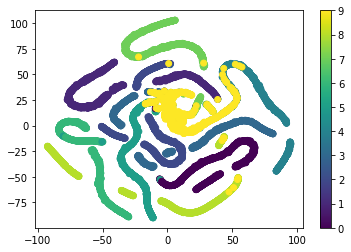

In [26]:
predict_y = np.concatenate([normals1, abnormals])
diflabel = np.ones_like(different)*9
test_y = np.concatenate([norm_labels, diflabel])

tSNE_metrics = TSNE(n_components=2, random_state=0).fit_transform(predict_y)
plt.scatter(tSNE_metrics[:, 0], tSNE_metrics[:, 1], c=test_y)
plt.colorbar()
plt.savefig('tsne_abnormals.png')
plt.show()

## plot roc curve

In [67]:
predict_y = np.concatenate([same, different])
samelabel = np.ones_like(same)
diflabel = np.zeros_like(different)
test_y = np.concatenate([samelabel, diflabel])

In [68]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

# FPR, TPR(, しきい値) を算出
fpr, tpr, thresholds = metrics.roc_curve(test_y, predict_y)

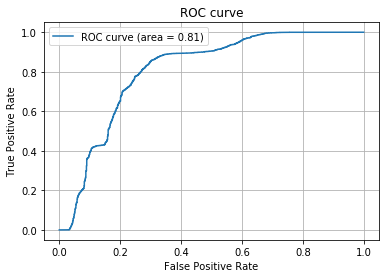

In [69]:
# ついでにAUCも
auc = metrics.auc(fpr, tpr)

# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)